In [1]:
import xarray as xr
import xroms
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import cmocean.cm as cmo
import cf_xarray
import xcmocean
import RePlots as rp
from glob import glob

In [2]:
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'

In [12]:
# files = glob('/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/*')
# files = glob('/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/GOM*.ocn.hi.????-*.nc')
files = glob('/ihesp/user/liu6/GOM_9k_nature_copernicus/Orig/GOM*.ocn.hi.2017-*.nc')
files.sort()
ds = xroms.open_mfnetcdf(files, chunks='auto')

In [13]:
#set up plotting stuff
pc = cartopy.crs.PlateCarree()  # to match lon/lat
proj = cartopy.crs.LambertConformal(central_longitude=-90)  # projection for plot

In [14]:
%%time
sst_slice = ds.temp.cf.isel(Z=-1, drop=True).chunk({'xi_rho': -1}).xroms.isoslice(-86, ds.temp.lon_rho, axis='X')
sst_slice_mean = sst_slice.cf.mean('T', skipna=False)
hov = (sst_slice - sst_slice_mean).cf.groupby("T.dayofyear").mean(skipna=False).cf.guess_coord_axis()
hov = hov.compute()

CPU times: user 25.1 s, sys: 21.1 s, total: 46.2 s
Wall time: 3min 8s


In [15]:
%%time
EKE = ds.xroms.EKE.cf.mean('T', skipna=False)
EKE = EKE.compute()

CPU times: user 43.1 s, sys: 15.4 s, total: 58.5 s
Wall time: 1min 26s


In [16]:
%%time
SST = ds.temp.cf.isel(Z=-1).cf.mean('T', skipna=False)
SST = SST.compute()

CPU times: user 19.5 s, sys: 24.3 s, total: 43.8 s
Wall time: 1min 51s


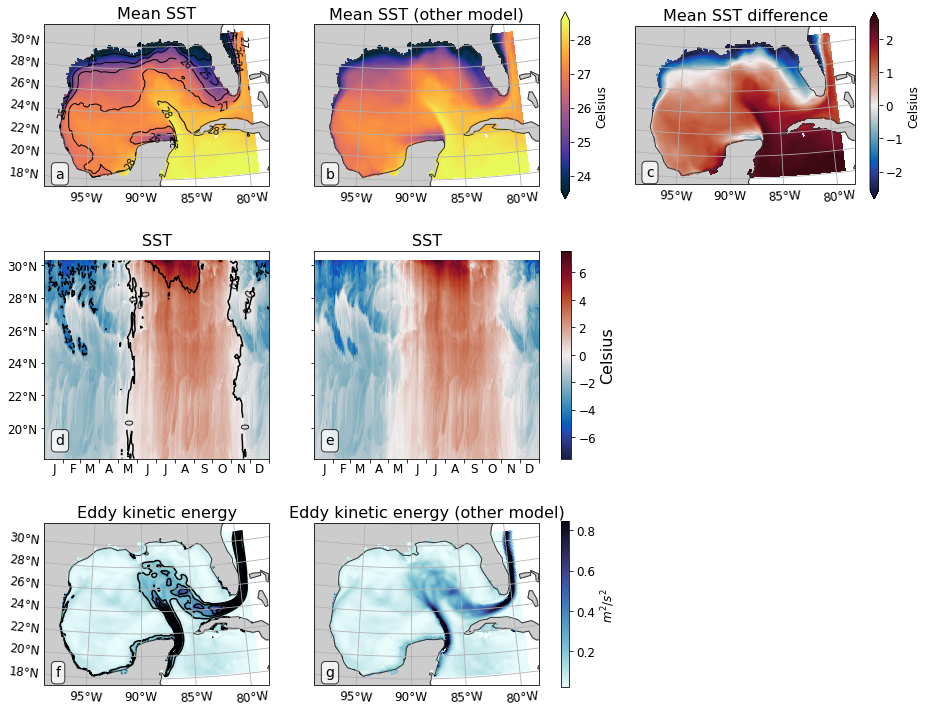

In [17]:
fig = plt.figure(figsize=(15,13))
nrows, ncols = 3, 3

titlesize = 16
ticksize = 12

## Mean SSTs ##
ax1 = plt.subplot(nrows, ncols, 1, projection=proj)
pargs, oargs = rp.setup_map(ax=ax1, title='Mean SST', titlesize=titlesize, xticks=np.arange(-95,-75,5),
                            ticklabelsize=ticksize, subargs={'label': 'a', 'loc': 'bottom left'})
SST.cmo.cfpcolormesh(**pargs)
cs = SST.cf.plot.contour(**pargs, colors='k', linewidths=1)
ax1.clabel(cs, inline=1, fontsize=10, fmt='%d')  # add labels to contours


ax2 = plt.subplot(nrows, ncols, 2, projection=proj)
pargs, oargs = rp.setup_map(ax=ax2, left_labels=False, title='Mean SST (other model)', titlesize=titlesize, 
                            ticklabelsize=ticksize, xticks=np.arange(-95,-75,5), 
                            subargs={'label': 'b', 'loc': 'bottom left'})
im = SST.cmo.cfplot(**pargs)
rp.cbar(im, ax=[ax1,ax2], label='Celsius', labelsize='large', ticksize='large', extend='both', shrink=0.9)


ax3 = plt.subplot(nrows, ncols, 3, projection=proj)
pargs, oargs = rp.setup_map(ax=ax3, left_labels=False, title='Mean SST difference', titlesize=titlesize, 
                            ticklabelsize=ticksize, xticks=np.arange(-95,-75,5), 
                            subargs={'label': 'c', 'loc': 'bottom left'})  # making up new variable to show difference
im = (SST-26).cmo.cfplot(**pargs)
rp.cbar(im, ax=ax3, label='Celsius', labelsize='large', ticksize='large', extend='both', shrink=0.9, pad=0.06)


## Hovmoller ##
ax4 = plt.subplot(nrows, ncols, 4)
pargs, _ = rp.setup_hov(hov, ax4, xaxis='time', yaxis='lat', title='SST', titlesize=titlesize, 
                        ticklabelsize=ticksize, 
                        subargs={'label': 'd', 'loc': 'bottom left'})
hov.cmo.cfplot(**pargs)
cs = hov.squeeze().cmo.cfcontour(**pargs, levels=5, colors='k')
ax4.clabel(cs, inline=1, fontsize=10, fmt='%d')


ax5 = plt.subplot(nrows, ncols, 5)
pargs, _ = rp.setup_hov(hov, ax5, xaxis='time', yaxis='lat', xticklabels=True, yticklabels=False,
                  title='SST', titlesize=titlesize, ticklabelsize=ticksize, 
                  subargs={'label': 'e', 'loc': 'bottom left'})
im = hov.cmo.cfplot(**pargs)
rp.cbar(im, ax=[ax4,ax5], labelsize=16, label='Celsius', ticksize='large')


## EKE ##
ax7 = plt.subplot(nrows, ncols, 7, projection=proj)
pargs, oargs = rp.setup_map(ax=ax7, title='Eddy kinetic energy', titlesize=titlesize, xticks=np.arange(-95,-75,5),
                            ticklabelsize=ticksize, subargs={'label': 'f', 'loc': 'bottom left'})
EKE.cmo.cfplot(**pargs)
cs = EKE.cf.plot.contour(**pargs, colors='k')


ax8 = plt.subplot(nrows, ncols, 8, projection=proj)
pargs, oargs = rp.setup_map(ax=ax8, left_labels=False, title='Eddy kinetic energy (other model)', 
                            titlesize=titlesize, ticklabelsize=ticksize, 
                            xticks=np.arange(-95,-75,5), subargs={'label': 'g', 'loc': 'bottom left'})
im = EKE.cmo.cfplot(**pargs)
rp.cbar(im, ax=[ax7,ax8], label='$' + EKE.units +'$', shrink=0.8, labelsize='large', ticksize='large');
